In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Rows: 303 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (13): index, age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
dbl (6): index, age, sex, cp, chol, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 200 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, thalach, exang, oldpeak, slope, ca, thal
dbl (6): index, age, sex, cp, restecg, num

ℹ Use `s

age,count
<dbl>,<int>
34,1
35,3
37,1
39,3
40,1
41,9
42,5
43,5
44,8


cp,count
<dbl>,<int>
1,14
2,31
3,58
4,59


age,cp,trestbps,chol
<dbl>,<dbl>,<dbl>,<dbl>
52.82716,3,129.1728,244.9136


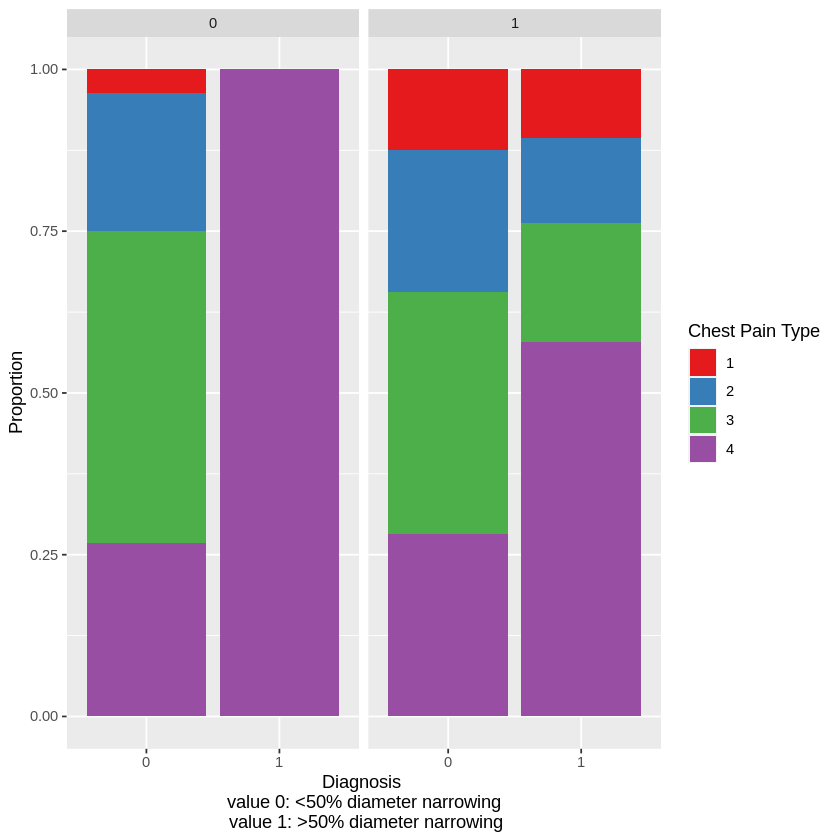

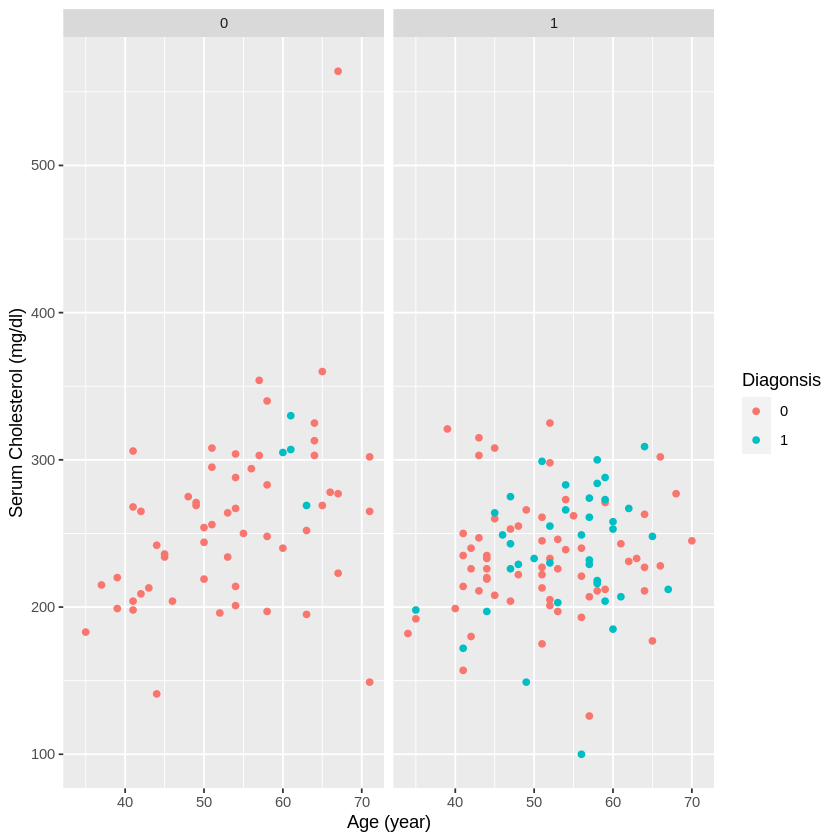

In [38]:
# Setting column names

colnames1 <- c("index", "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
              "slope", "ca", "thal", "num")

colnames2 <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
              "slope", "ca", "thal", "num")

# Reading in the data
cleveland_raw <- read_csv("data/cleveland.csv", col_name = colnames1, , skip = 1)
switzerland_raw <- read_csv("data/switzerland.csv", col_name = colnames1, , skip = 1)
va_raw <- read_csv("data/va_longbeach.csv", col_name = colnames1, , skip = 1)
hungary <- read_csv("data/hungary.csv", col_name = colnames2, skip = 1)


# Selecting the data without the index
cleveland <- select(cleveland_raw, -index)
switzerland <- select(switzerland_raw, -index)
va <- select(va_raw, -index)


# Filtering out the aggregated databases for bad data points
database_raw <- rbind(cleveland, switzerland, va, hungary)
database <- database_raw |>
            filter(age != "?") |>
            filter(sex != "?") |>
            filter(cp != "?") |>
            filter(trestbps != "?") |>
            filter(chol != "?") |>
            filter(fbs != "?") |>
            filter(restecg != "?") |>
            filter(thalach != "?") |>
            filter(exang != "?") |>
            filter(oldpeak != "?") |>
            filter(slope != "?") |>
            filter(ca != "?") |>
            filter(thal != "?") |>
            filter(num != "?") |>
            filter(exang != -9) |>
            filter(fbs != -9) |>
            filter(slope != -9) |>
            filter(ca != -9) |>
            filter(ca != 9) |>
            filter(num != 2) |>
            filter(num != 3) |>
            filter(num != 4) |>
            mutate_if(is.character, as.numeric)|>
            mutate(scaled_trestbps=scale(trestbps,center=TRUE),
                   scaled_chol=scale(chol,center=TRUE))

# Totally, there are 5 data frames:
# 1. cleveland
# 2. switzerland
# 3. va
# 4. hungary
# 5. database

# splitting data into training data and testing data
database_split<-initial_split(database, prop = 0.75,strata = num)
database_train<-training(database_split)
database_test<-testing(database_split)

# count the number of patients with different ages
count_age <- database_train |>
             group_by(age) |>
             summarize(count = n())
count_age

# count the number of patients with different types of chest pain
count_cp <- database_train |>
             group_by(cp) |>
             summarize(count = n())
count_cp

#count the average value of variables
group_mean <- database_train |>
              summarize(across(age:num, mean, na.rm = TRUE)) |>
              select(age, cp, trestbps, chol)
group_mean


# plotting with bar plot
cp_num_plot <- database_train |>
    ggplot(aes(x = as_factor(num), fill = as_factor(cp))) + 
    geom_bar(position = 'fill') +
    xlab('Diagnosis \n value 0: <50% diameter narrowing \n value 1: >50% diameter narrowing') +
    ylab('Proportion') +
    labs(fill = "Chest Pain Type") +
    facet_grid(cols = vars(sex)) +
    scale_fill_brewer(palette = "Set1")
cp_num_plot

# plotting with scatter plot
age_chol_plot <- database_train |>
    ggplot(aes(x = age, y = chol, color = as_factor(num))) + 
    geom_point() +
    xlab('Age (year)') +
    ylab('Serum Cholesterol (mg/dl)') +
    labs(color = "Diagonsis") +
    facet_grid(cols = vars(sex))
age_chol_plot